# Plant Disease classifier

Para este proyecto construímos un clasificador que permita detectar enfermedades en ciertas plantas de cultivo por medio de imágenes de hojas. En total se tienen 39 clases, que incluyen manzana, cereza, maíz, uva, naranja, durazno, pimienta, papa, soya, fresa y tomate. Cada una de estas se divide en subcategorías que incluyen diferentes enfermedades propias de cada planta y una categoría sana para cada una. También se incluye un fondo sin hojas con el fin de poder identificar cuando no hay una hoja en la imagen.

## Datos

## Separar los datos 

Las imágenes fueron separadas en datos de entrenamiento, prueba y validacion utilizando las librerías 'os' y 'splitfolders'

In [4]:
import splitfolders
import os

os.makedirs('C:/Users/Usuario/OneDrive/Documentos/IA/Plant village/Data/SplitData') #Crea una carpeta para almacenar las imágenes separadas
os.makedirs('C:/Users/Usuario/OneDrive/Documentos/IA/Plant village/Data/SplitData/train') #crea una subcarpeta de entrenamiento
os.makedirs('C:/Users/Usuario/OneDrive/Documentos/IA/Plant village/Data/SplitData/val') #crea una subcarpeta de validación
os.makedirs('C:/Users/Usuario/OneDrive/Documentos/IA/Plant village/Data/SplitData/test') #crea una subcarpeta de prueba

loc = "C:/Users/Usuario/OneDrive/Documentos/IA/Plant village/Data/Plant_leave_diseases_dataset" 

splitfolders.ratio(loc,output = "C:/Users/Usuario/OneDrive/Documentos/IA/Plant village/Data/SplitData",seed = 42,ratio = (0.70,.15,.15)) #Se distribuyen las imágenes aleatoreamente.

# Crear las etiquietas para cada imagen

En el modulo de preprocesamiento existen diferentes funciones quepermiten crear las etiquetas para las imágenes. En este caso usaremos 'image_dataset_from_directory' que asigna a cada imagen la etiqueta correspondiente a la carpeta en la cual se encuentra

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [6]:
train_dir = 'C:/Users/Usuario/OneDrive/Documentos/IA/Plant village/Data/SplitData/train'
val_dir = 'C:/Users/Usuario/OneDrive/Documentos/IA/Plant village/Data/SplitData/val'
test_dir  = 'C:/Users/Usuario/OneDrive/Documentos/IA/Plant village/Data/SplitData/test'

train_data = image_dataset_from_directory(train_dir,label_mode="categorical",image_size = (224,224),
                                          batch_size = 32,seed = 123,shuffle = True)


val_data = image_dataset_from_directory(val_dir,label_mode="categorical",image_size = (224,224),
                                          batch_size = 32,seed = 123,shuffle = False)


test_data = image_dataset_from_directory(test_dir,label_mode="categorical",image_size = (224,224),
                                          batch_size = 32,seed = 123,shuffle = False)

Found 38797 files belonging to 39 classes.
Found 8300 files belonging to 39 classes.
Found 8351 files belonging to 39 classes.


Observamos las 39 clases existentes en nuestra base de datos

In [7]:
print(train_data.class_names)
num_classes=len(train_data.class_names)


['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl

# Modelo 

Se añaden un callback "early stop"

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 5,min_delta = 0.0001,restore_best_weights = True,verbose = 1)

### Feature extractor
El feature extractor será el modelo base, en este caso se trata de la arquitectura DenseNet169, un modelo de redes convolusionales preentrenado de 169 capas.

In [9]:
base_model = tf.keras.applications.DenseNet169(include_top = False)

Debido a que las pruebas iniciales mostraron sobreajuste se añadió una capa de 'augmentation', es decir, una capa que altera las imágenes, cambiando la altura, el ancho, la rotación y reescalamiento

In [10]:
from tensorflow.keras.layers.experimental import preprocessing
data_aug = tf.keras.Sequential([
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.Rescaling(1/255.)
],name = "data_augmentation_layer")

Adicionalmente se añade una capa de Average Pooling y dos capas Dense utilizando relu como función de activación

de esta forma el modelo se construye de la siguiente manera:

In [11]:
inputs = layers.Input(shape = (224,224,3),name = "Input_layer") #capa de entrada
x = data_aug(inputs) #capa de augmentation
x = base_model(x) #red densenet (extractor de features)
x = layers.GlobalAveragePooling2D(name = "Global_average_pooling_layer")(x) #global average pooling
x = layers.Dense(32,activation = "relu",kernel_initializer = tf.keras.initializers.HeNormal(),name = "Dense_layer_1")(x)#capa densa 1
x = layers.Dense(39,name = "Dense_layer_2")(x) #capa densa 2
outputs = layers.Activation("softmax",dtype = tf.float32)(x) #softmax para clasificar
model = tf.keras.Model(inputs,outputs) #creacion del modelo

## Resumen del modelo final

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, None, None, 3)    0         
 quential)                                                       
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 Global_average_pooling_laye  (None, 1664)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 Dense_layer_1 (Dense)       (None, 32)                53280     
                                                                 
 Dense_layer_2 (Dense)       (None, 39)                1287  

Nota: Las dimensiones de las imágenes a partir de la segunda capa son flexibles y variables debido a la capa de augmentation que altera las dimensiones de la imagen, por lo que se muestran las dimensiones como 'None'

## Compilar el modelo

In [13]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

## Entrenamos el modelo

Utilizamos la librería psutil para poder agregar prioridad de la CPU al entrenamiento del modelo, debido a que es un proceso bastante largo y computacionalmente complejo

In [14]:
import psutil

# Obtener el ID de proceso del notebook de Jupyter
pid = os.getpid()

# Establece la prioridad de rendimiento al nivel más alto
p = psutil.Process(pid)
p.nice(psutil.REALTIME_PRIORITY_CLASS)

Entrenamos el modelo

In [15]:
history= model.fit(train_data,epochs = 3,steps_per_epoch=len(train_data),
                        validation_data = val_data,validation_steps = int(0.25*len(val_data)),
                        callbacks = early_stop)

Epoch 1/3
1213/1213 [==============================] - 5588s 5s/step - loss: 0.9445 - accuracy: 0.7505 - val_loss: 0.3442 - val_accuracy: 0.8942
Epoch 2/3
1213/1213 [==============================] - 5520s 5s/step - loss: 0.3468 - accuracy: 0.8954 - val_loss: 0.2462 - val_accuracy: 0.9154
Epoch 3/3
1213/1213 [==============================] - 5545s 5s/step - loss: 0.2666 - accuracy: 0.9159 - val_loss: 0.1889 - val_accuracy: 0.9394


## Resultados

Se almacenan los pesos en formato h5 para poder usarlos posteriormente en la aplicación que se planea hacer

In [16]:
model.save_weights('C:/Users/Usuario/OneDrive/Documentos/IA/Plant village/Data/results/weights.h5')

Extraemos y graficamos la pérdida y precisión de cada iteración

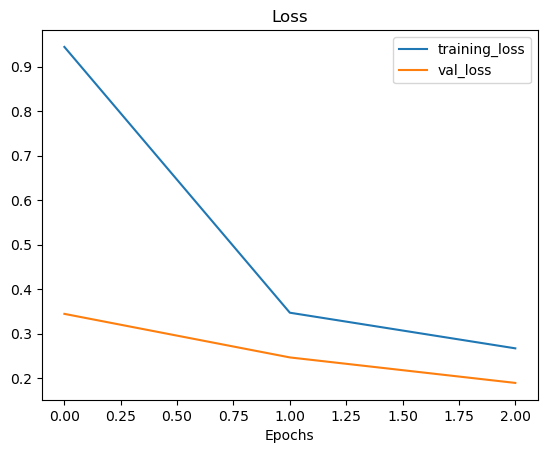

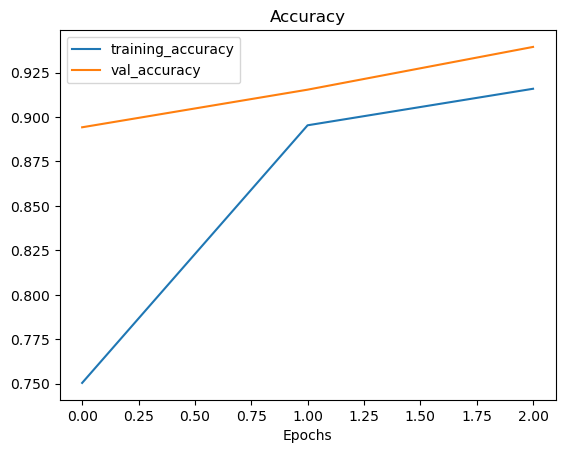

In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mping

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(history.history['loss']))

plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

Evaluamos los resultados con el conjunto de prueba

In [19]:
results = model.evaluate(test_data)

print("Pérdida en los datos de prueba:", results[0])
print("Precisión en los datos de prueba:", results[1])

261/261 [==============================] - 1178s 5s/step - loss: 0.2541 - accuracy: 0.9151
Pérdida en los datos de prueba: 0.2541446387767792
Precisión en los datos de prueba: 0.9150999784469604


Volvemos a establecer la prioridad normal

In [20]:
# Obtener el ID de proceso del notebook de Jupyter
pid = os.getpid()

# Establece la prioridad de rendimiento al nivel normal (por defecto)
p = psutil.Process(pid)
p.nice(psutil.NORMAL_PRIORITY_CLASS)

# Prueba manual

Se realizaron pruebas indivuduales con imágenes tomadas de internet almacenándolas en una carpeta independiente y usando el método predict sobre esta imagen pudimos observar resultados satisfactorios

In [69]:
loctest='C:/Users/Usuario/OneDrive/Documentos/IA/Plant village/Data/pruebaind'
imgprueba=image_dataset_from_directory(loctest,label_mode="categorical",image_size = (224,224),
                                          batch_size = 32,seed = 123,shuffle = True)

Found 1 files belonging to 1 classes.


In [70]:
predicciones=model.predict(imgprueba)
clase_predicha = tf.argmax(predicciones, axis=1)
etiqueta_predicha = train_data.class_names[clase_predicha.numpy()[0]]
etiqueta_predicha

1/1 [==============================] - 0s 469ms/step


'Tomato___Late_blight'